In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.18.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv

# 定义训练集和测试机的文件名路径
train_file = './data/titanic/train.csv'
eval_file = './data/titanic/eval.csv'

# 用 pandas 把两个数据集读取进来
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [3]:
# survived 是我们要预测的值, 所以先从特征值里面删除
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [4]:
# describe() 数据集中的统计量
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


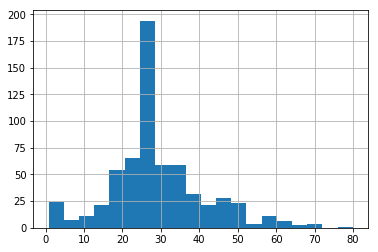

In [6]:
# 泰坦尼克号上的乘客年龄分布, bins=分成多少份
train_df.age.hist(bins = 20)

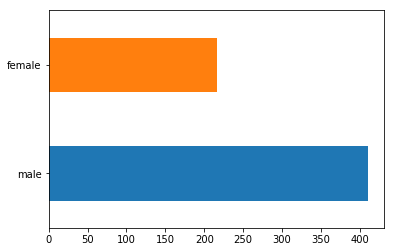

In [7]:
# 不同性别的人各有多少
train_df.sex.value_counts().plot(kind = 'barh')

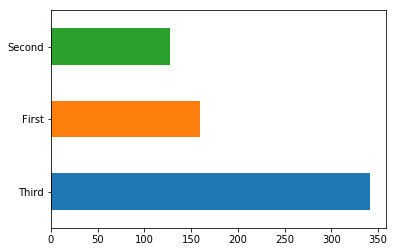

In [8]:
# 不同仓位的乘客各有多少
train_df['class'].value_counts().plot(kind = 'barh')

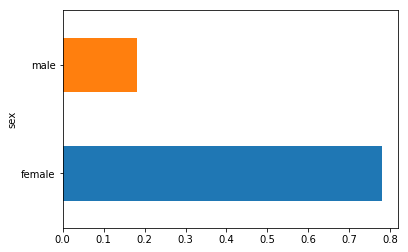

In [9]:
# 获救人群性别占比
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind = 'barh')

In [10]:
# 最简单的机器学习输入数据是把预测值去掉，把数据用矩阵形式输入
# 这里用 feature_column 来对数据列做预处理

# 定义离散特征
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                      'deck', 'embark_town', 'alone']
# 定义连续特征
numeric_columns = ['age', 'fare']

# 特征预处理,定义在 feature_column 集合里
feature_columns = []
# 对每一个离散特征做处理
for categorical_column in categorical_columns:
    # 获得离散特征所在列的所有可能的值
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    # onehot 编码
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

# 对每一个连续特征做处理
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [11]:
# 定义函数构建 Dataset
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [12]:
# data_df 是 pandas.DataFrame 结构, 查看一下将它变成字典的结构
dict(train_df)

{'age': 0      22.0
 1      38.0
 2      26.0
 3      35.0
 4      28.0
 5       2.0
 6      27.0
 7      14.0
 8       4.0
 9      20.0
 10     39.0
 11     14.0
 12      2.0
 13     28.0
 14     31.0
 15     28.0
 16     35.0
 17     28.0
 18     38.0
 19     28.0
 20     19.0
 21     28.0
 22     28.0
 23     40.0
 24     28.0
 25     28.0
 26     66.0
 27     28.0
 28     42.0
 29     28.0
        ... 
 597    35.0
 598    28.0
 599    28.0
 600     4.0
 601    16.0
 602    18.0
 603    45.0
 604    51.0
 605    24.0
 606    41.0
 607    24.0
 608    42.0
 609    27.0
 610    31.0
 611     4.0
 612    26.0
 613    47.0
 614    33.0
 615    47.0
 616    28.0
 617    15.0
 618    20.0
 619    19.0
 620    28.0
 621    22.0
 622    28.0
 623    25.0
 624    19.0
 625    28.0
 626    32.0
 Name: age, Length: 627, dtype: float64, 'alone': 0      n
 1      n
 2      y
 3      n
 4      y
 5      n
 6      n
 7      n
 8      n
 9      y
 10     n
 11     y
 12     n
 13     y
 14     n
 

In [13]:
# 构建训练集的 dataset
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [14]:
# 打印 train_dataset 的值
for x, y in train_dataset.take(1):
    print(x, y)
    # 发现 x 是一个字典, y 是一个列表

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'female', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([28., 28., 49., 28., 28.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 1, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([  7.75  , 146.5208, 110.8833,   9.5   ,   0.    ])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Third', b'First', b'First', b'Third', b'Second'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'B', b'C', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Queenstown', b'Cherbourg', b'Cherbourg', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'y'

In [15]:
# 构建好 Dataset 后, 需要把 feature_columns 和 dataset 结合使用 -> keras.layers.DenseFeatures 把 feature_columns 应用到 dataset 里
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[38.]
 [28.]
 [18.]
 [ 1.]
 [30.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [16]:
# 构建好 Dataset 后, 需要把 feature_columns 和 dataset 结合使用 -> keras.layers.DenseFeatures 把 feature_columns 应用到 dataset 里
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[43.      1.      0.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  26.25    1.      0.      0.      0.      0.      0.      0.      0.
   1.      0.      0.      0.      0.      1.      0.    ]
 [18.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   9.8417  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.

## 定义模型

In [19]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer = keras.optimizers.SGD(lr=0.01),
             metrics = ['accuracy'])

In [20]:
# 1. model.fit
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                   validation_data = eval_dataset,
                   steps_per_epoch = 20,
                   validation_steps = 8,
                   epochs = 100)

Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 1s 40ms/step - loss: 2.2299 - accuracy: 0.5813 - val_loss: 0.9216 - val_accuracy: 0.6758
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6961 - accuracy: 0.6719 - val_loss: 0.6453 - val_accuracy: 0.6758
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6656 - val_loss: 0.6813 - val_accuracy: 0.6328
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6385 - accuracy: 0.6406 - val_loss: 0.6017 - val_accuracy: 0.6953
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6096 - accuracy: 0.6719 - val_loss: 0.6395 - val_accuracy: 0.6797
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6938 - val_loss: 0.6148 - val_accuracy: 0.6680
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.7125 - val_loss: 0

20/20 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.7594 - val_loss: 0.5177 - val_accuracy: 0.7461
Epoch 59/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5580 - accuracy: 0.7266 - val_loss: 0.5424 - val_accuracy: 0.7383
Epoch 60/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5430 - accuracy: 0.7594 - val_loss: 0.5767 - val_accuracy: 0.6992
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.7547 - val_loss: 0.5131 - val_accuracy: 0.7422
Epoch 62/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5260 - accuracy: 0.7516 - val_loss: 0.5497 - val_accuracy: 0.7266
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.7203 - val_loss: 0.5166 - val_accuracy: 0.7422
Epoch 64/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5423 - accuracy: 0.7547 - val_loss: 0.5156 - val_accuracy: 0.7344
Epoch 65/100
20/20 

ValueError: Empty training data.

In [21]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. returun a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda: make_dataset(train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/7l/7__2pj9n7b36yhpdfxwkr3rr0000gn/T/tmp3lk7r54n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master'

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.